# Import package and function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
import pandas as pd
import os
%matplotlib inline

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["mathtext.fontset"] = "cm"

In [2]:
def NGD2L_TK_AS(T, epsilon, gamma, omegastar, deltastar, tau_y, Dmp):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    Kw = -Dmp*( 1/np.cos(deltastar)*np.exp(-epsilon*T)*np.cos(T*omegastar+deltastar) -np.exp(-gamma*T) )
    w = np.convolve(x, Kw, 'full')[:len(T):50]*dt
    return w/(dt)

# load files 

In [3]:
os.chdir('..')
data_folder = os.getcwd()+"\\Experimental_Data_Example\\"  # Note that use absolute path on your computer instead.
BS = loadmat(data_folder+'oled_boundary_set', squeeze_me =True)
ExpData = loadmat(data_folder+'OLED_Data\\merge_0224_Checkerboard_30Hz_27_15min_Br50_Q100', squeeze_me =True)

In [4]:
cn = 9
dt = 1/60
timeBinNum = 60
Taxis = np.arange(timeBinNum)*dt

checkerboard = ExpData['bin_pos']
fs = 1.5
GFcheckerboard = np.array([gaussian_filter(cb.astype(float), fs) for cb in checkerboard])
GFCcheckerboard = GFcheckerboard - np.mean(GFcheckerboard, axis = 0)
rstate, _ = np.histogram(ExpData['reconstruct_spikes'][cn-1], np.arange(len(checkerboard)+1)*dt)

In [5]:
STK = np.zeros([timeBinNum,27,27])
for i in range(timeBinNum): #1s
    for ii in np.arange(0, len(checkerboard)-i):
        STK[i,:,:] += rstate[ii+i]*GFCcheckerboard[ii,:,:]
    STK[i,:,:] /= np.sum(rstate[:len(checkerboard)-i])

# SVD

In [7]:
rSTK = STK[:,:,:].reshape((STK.shape[0],-1))
U,sigma,VT=np.linalg.svd(rSTK)

In [8]:
sigma/np.sum(sigma)

array([0.18628532, 0.04868457, 0.04146231, 0.03654136, 0.03598186,
       0.03356175, 0.03232673, 0.02973532, 0.02753035, 0.02719149,
       0.02555667, 0.0250933 , 0.02305748, 0.02286642, 0.02205487,
       0.02146124, 0.01917402, 0.01876313, 0.01795403, 0.01729014,
       0.01704447, 0.01661698, 0.01580708, 0.01496271, 0.0141477 ,
       0.0131511 , 0.01309089, 0.01228124, 0.01196197, 0.01128178,
       0.01097613, 0.01027374, 0.00991452, 0.00968256, 0.00888758,
       0.00815986, 0.00774709, 0.0072162 , 0.00694175, 0.00666991,
       0.0060586 , 0.00584418, 0.00522147, 0.00519361, 0.00476832,
       0.00428073, 0.00408473, 0.00370047, 0.00334553, 0.00302814,
       0.00252394, 0.00249425, 0.00230793, 0.00176902, 0.00167902,
       0.00152203, 0.00102222, 0.00085442, 0.00060446, 0.00030931])

(0.0, 1.0)

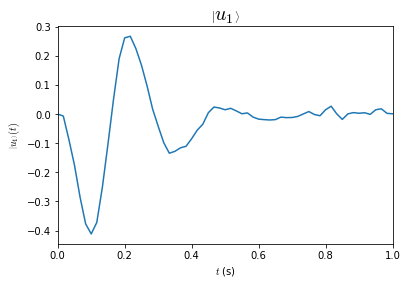

In [9]:
plt.plot(np.arange(timeBinNum+1)*dt, np.append(0,U[:,0]))
plt.xlabel(r'$t$ (s)')
plt.ylabel(r'$\left| u_1 \right\rangle(t)$')
plt.title(r'$\left| u_1 \right\rangle$', fontsize=20)
plt.xlim([0,1])

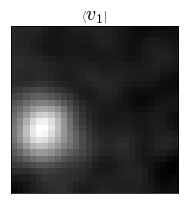

In [10]:
plt.imshow( VT[0,:].reshape((27,27)) , cmap='gray')
plt.title(r'$\left\langle {v_1} \right|$', fontsize=20)
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)
plt.gcf().set_size_inches(3,3.5)

# Figure 3.4: A reconstructed separable STK from SVD compared with the original STK.

In [12]:
SVDtogather =VT[0,:].reshape((27,27))* U[0,0]
STKtogather = STK[0,:,:]
for i in np.arange(1,18):
    SVDtogather = np.hstack((SVDtogather, VT[0,:].reshape((27,27)) * U[i,0] ))
    STKtogather = np.hstack((STKtogather, STK[i,:,:] ))
Togather = np.vstack((STKtogather, SVDtogather))
imshowdict = {'cmap': 'gray',
              'vmin': np.min(Togather),
              'vmax': np.max(Togather)}

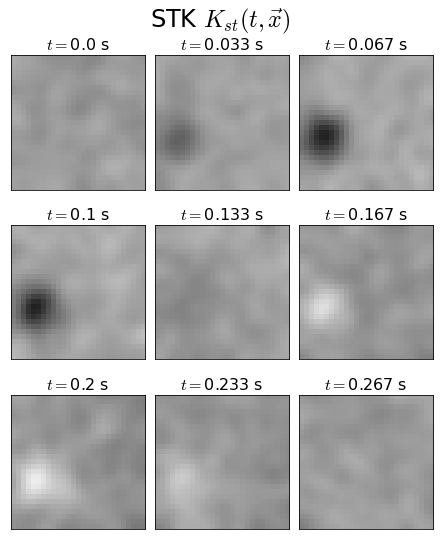

In [13]:
fig, ax = plt.subplots(3,3, constrained_layout=True)
for i in np.arange(9):
    ax.flatten()[i].imshow(STK[i*2,:,:], **imshowdict)
    ax.flatten()[i].set_title(r'$t=$'+str(np.round((i*2)/60, 3))+' s', fontsize = 16)
    ax.flatten()[i].axes.xaxis.set_visible(False)
    ax.flatten()[i].axes.yaxis.set_visible(False)
# fig.tight_layout()
fig.suptitle(r'STK $K_{st}(t,\vec{x})$', fontsize=24)
fig.set_size_inches(6,7.5)

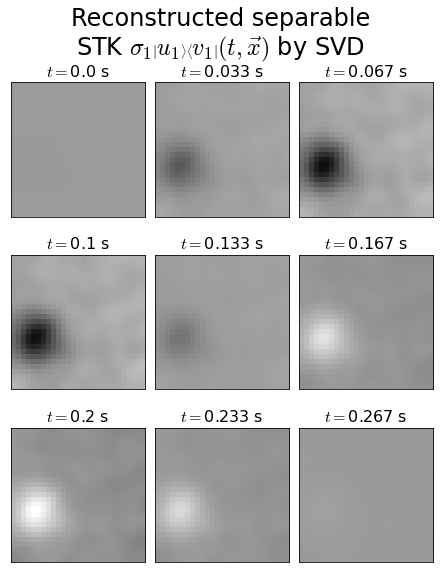

In [14]:
fig, ax = plt.subplots(3,3, constrained_layout=True)
for i in range(9):
    ax.flatten()[i].imshow(VT[0,:].reshape((27,27)) * U[i*2,0], **imshowdict)
    ax.flatten()[i].set_title(r'$t=$'+str(np.round((i)/30, 3))+' s', fontsize = 16)
    ax.flatten()[i].axes.xaxis.set_visible(False)
    ax.flatten()[i].axes.yaxis.set_visible(False)
# fig.tight_layout()
fig.suptitle('Reconstructed separable\n'+r'STK $\sigma_1 \left| u_1 \right\rangle \left\langle {v_1} \right|(t,\vec{x})$ by SVD', fontsize=24)
fig.set_size_inches(6,8)